# The Quantum Approximate Optimization Algorithm in PennyLane

In [1]:
import pennylane as qml
from pennylane import qaoa
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize
import time

The goal of the PennyLane library is to provide a collection of general, yet powerful functions that the user may apply to a wide variety of use-cases.

Oftentimes, when considering thinking of quantum circuits or variational ansatzae, it is convenient to consider these processes as defined by a series of quantum gates. However, as it turns out, there are many instances where it is useful to think of a quantum circuit in terms of a *Hamiltonian*. For instance, in quantum mechanics, a unitary transformation of great interest is that of time-evolution:

$$U \ = \ e^{-i \hat{H} t / \hbar}$$

This unitary is clearly defined completely in terms of a Hamiltonian, $\hat{H}$ and a scalar $t$. Mimicing the general form of the time-evolution unitary, as this is the most general example of a unitary determined by a Hamiltonian, we define the ``ApproxTimeEvolution`` template in PennyLane

Another fundamental idea within quantum computation is repetedly applictions of quantum gates. This can be seen everywhere, from amplitude amplification in Grover's algorithm and HHL, to layers in quantum neural networks, to Trotterization in quantum simulation. We therefore define the ``qml.layer`` method in PennyLane to alternate an arbitrary unitary. This general method allows us to take a function containing quantum operations, a template, or even a single quantum gate and repeatedly apply it.

### Defining a QAOA Travelling Salesman Workflow

With all of the general functionality that we outlined, we can now demonstrate how it can be used to create a QAOA workflow.

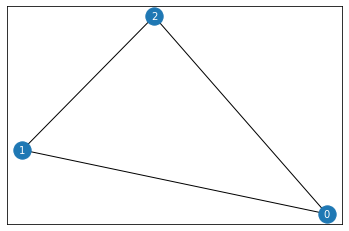

In [28]:
# Defines the graph on which we perform TSP

graph = nx.Graph()
weighted_edges = [
    (0, 1, 0.4),
    (1, 2, 0.6),
    (2, 0, 0.2)
]
for v1, v2, weight in weighted_edges:
    graph.add_edge(v1, v2, weight=weight)

pos = nx.spring_layout(graph)

nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges)
nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif', font_color='white')
plt.show()

In [29]:
# Defines the wire grid used when encoding the TSP problem

wire_grid = np.array(range(9))
wire_grid = list(np.reshape(wire_grid, (3, 3)))
wire_grid = [list(i) for i in wire_grid]

In [30]:
# Defines the Hamiltonian and mixer

cost_h, mixer_h = qaoa.travelling_salesman(graph, wire_grid)
print(cost_h)
print(mixer_h)

(0.4) [Z0 Z4]
+ (0.4) [Z1 Z3]
+ (0.4) [Z3 Z7]
+ (0.4) [Z4 Z6]
+ (0.4) [Z6 Z1]
+ (0.4) [Z7 Z0]
+ (0.2) [Z0 Z5]
+ (0.2) [Z2 Z3]
+ (0.2) [Z3 Z8]
+ (0.2) [Z5 Z6]
+ (0.2) [Z6 Z2]
+ (0.2) [Z8 Z0]
+ (0.6) [Z1 Z5]
+ (0.6) [Z2 Z4]
+ (0.6) [Z4 Z8]
+ (0.6) [Z5 Z7]
+ (0.6) [Z7 Z2]
+ (0.6) [Z8 Z1]
(0.125) [X0 X3 X1 X4]
+ (0.125) [X0 X3 Y1 Y4]
+ (0.125) [X0 Y3 X1 Y4]
+ (-0.125) [X0 Y3 Y1 X4]
+ (-0.125) [Y0 X3 X1 Y4]
+ (0.125) [Y0 X3 Y1 X4]
+ (0.125) [Y0 Y3 X1 X4]
+ (0.125) [Y0 Y3 Y1 Y4]
+ (0.125) [X3 X6 X4 X7]
+ (0.125) [X3 X6 Y4 Y7]
+ (0.125) [X3 Y6 X4 Y7]
+ (-0.125) [X3 Y6 Y4 X7]
+ (-0.125) [Y3 X6 X4 Y7]
+ (0.125) [Y3 X6 Y4 X7]
+ (0.125) [Y3 Y6 X4 X7]
+ (0.125) [Y3 Y6 Y4 Y7]
+ (0.125) [X6 X0 X7 X1]
+ (0.125) [X6 X0 Y7 Y1]
+ (0.125) [X6 Y0 X7 Y1]
+ (-0.125) [X6 Y0 Y7 X1]
+ (-0.125) [Y6 X0 X7 Y1]
+ (0.125) [Y6 X0 Y7 X1]
+ (0.125) [Y6 Y0 X7 X1]
+ (0.125) [Y6 Y0 Y7 Y1]
+ (0.125) [X0 X3 X2 X5]
+ (0.125) [X0 X3 Y2 Y5]
+ (0.125) [X0 Y3 X2 Y5]
+ (-0.125) [X0 Y3 Y2 X5]
+ (-0.125) [Y0 X3 X2 Y5]
+ (0.125) [Y

In [55]:
# Defines the QAOA circuit

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [56]:
dev = qml.device('default.qubit', wires=16, shots=20)


def circuit(params, **kwargs):
    params = [params[0:2], params[2:4]]
    
    for i in range(4):
        qml.PauliX(wires=wire_grid[i][i])
    
    qml.layer(qaoa_layer, 2, params[0], params[1])
    
    return qml.

cost_function = qml.VQECost(circuit, cost_h, dev)

In [57]:
# Defines the optimizer and parameters

params = [[0.1, 0.1], [0.1, 0.1]]
start = time.time()
opt = minimize(cost_function, params, method='COBYLA', options={'maxiter':1})
end = time.time()
print("Time: {}".format(end - start))
print(opt)

print("Optimal Params: {}".format(opt['x']))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
Time: 639.4322469234467
     fun: 8.881869927979308
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1
  status: 2
 success: False
       x: array([[0.1, 0.1],
       [0.1, 0.1]])
Optimal Params: [[0.1 0.1]
 [0.1 0.1]]


In [58]:
@qml.qnode(dev)
def qaoa_circuit(gamma, alpha):
    circuit(gamma+alpha)
    return qml.probs(wires=range(9))

dict_vals = qaoa_circuit(list(opt['x'][0]), list(opt['x'][1]))
print(dict_vals)

49
[3.00455122e-33 4.54182778e-36 1.84110249e-34 1.26408369e-36
 3.59744755e-33 2.28854327e-34 3.01625980e-34 4.65240516e-36
 1.38190722e-31 5.02144841e-34 1.06094866e-32 1.33452051e-35
 6.34718821e-33 8.48428889e-35 7.47743206e-35 1.97982384e-35
 7.51916517e-33 5.79875317e-36 1.92337821e-34 8.15877894e-39
 7.55453022e-34 2.45490901e-37 2.42904549e-34 5.60196527e-38
 2.47189523e-32 1.22091262e-36 5.42094791e-33 4.24325910e-37
 4.82603765e-33 5.16177757e-37 5.11200471e-63 1.81769164e-63
 1.05275763e-32 1.07194585e-33 6.12104129e-34 4.22670413e-35
 1.44671355e-03 3.19935785e-05 7.54684044e-34 1.94300148e-35
 3.51858170e-02 7.86409135e-05 6.13236007e-32 1.11862122e-33
 2.36157287e-32 3.08286523e-33 5.86953717e-33 1.93726365e-35
 8.16916802e-04 1.60264664e-33 5.78845484e-34 7.02760655e-35
 1.97138926e-33 3.14078158e-35 2.46064462e-34 3.14732961e-35
 7.50605469e-32 6.56423183e-34 4.81975863e-33 1.17213965e-33
 2.41752242e-33 5.45747871e-34 3.47542086e-62 3.95290871e-63
 1.29350508e-34 2.928

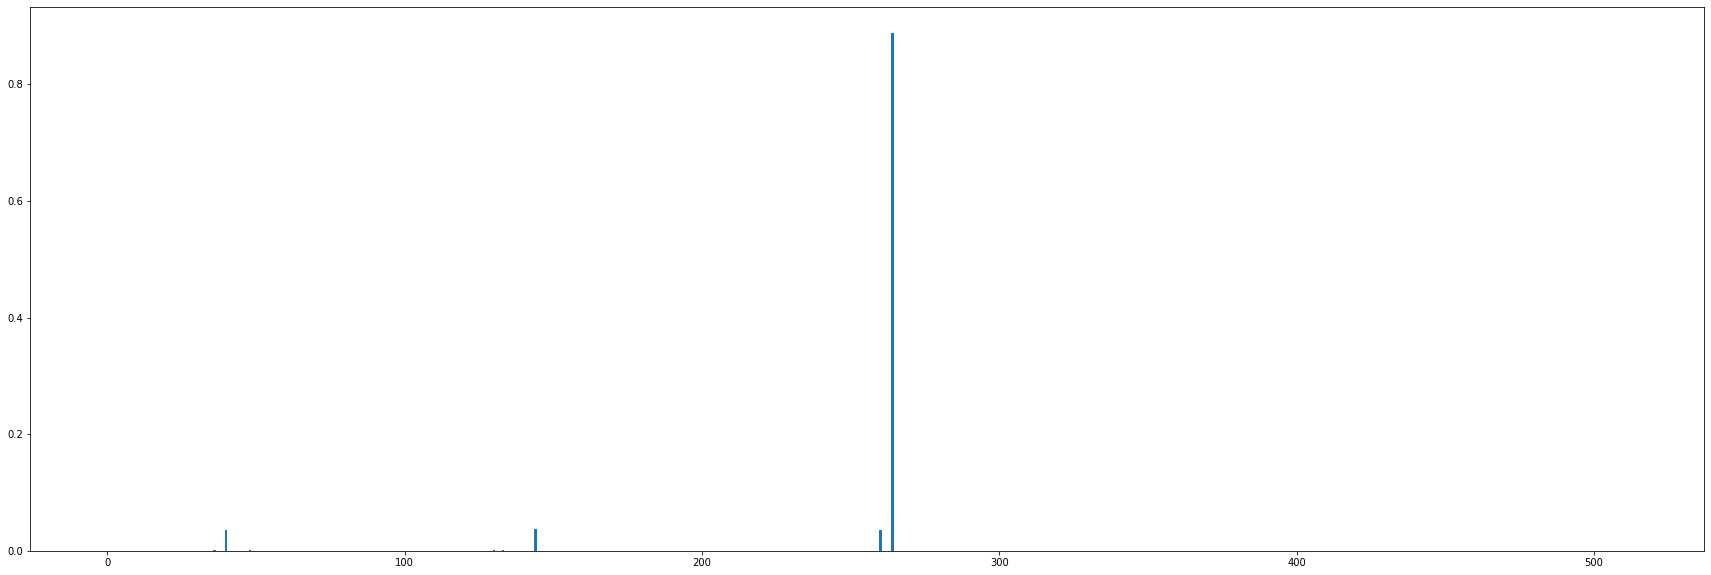

[264, 144, 260, 40, 36, 48, 133, 130, 258, 80, 132, 41, 72, 73, 37, 66, 131, 67, 266, 268, 296, 265, 256, 456, 270, 8, 332, 392, 328, 285, 146, 452, 280, 360, 288, 56, 300, 42, 282, 281, 269, 408, 136, 416, 418, 400, 388, 267, 176, 320, 273, 257, 24, 302, 262, 44, 424, 168, 314, 284, 283, 208, 298, 261, 312, 386, 148, 384, 324, 104, 364, 152, 394, 426, 129, 10, 212, 32, 290, 145, 272, 366, 344, 92, 420, 348, 396, 16, 460, 88, 76, 12, 46, 292, 26, 150, 356, 28, 58, 334, 240, 147, 184, 160, 156, 4, 362, 128, 432, 45, 0, 68, 60, 330, 182, 137, 178, 52, 154, 276, 153, 49, 448, 259, 108, 74, 180, 192, 96, 310, 316, 59, 43, 232, 33, 404, 149, 162, 294, 464, 422, 90, 402, 20, 38, 450, 279, 244, 397, 278, 57, 277, 428, 236, 34, 89, 50, 100, 61, 110, 352, 263, 9, 112, 210, 141, 120, 308, 134, 164, 274, 389, 220, 326, 106, 301, 6, 186, 304, 224, 390, 200, 122, 228, 124, 170, 135, 54, 22, 214, 430, 194, 303, 84, 5, 78, 354, 216, 322, 275, 196, 165, 18, 242, 2, 197, 358, 64, 81, 82, 172, 336, 167,

In [59]:
plt.figure(figsize=(30, 10))
plt.bar(range(2**9), dict_vals)
plt.show()

y = [list(dict_vals).index(i) for i in np.sort(dict_vals)[::-1]]
print(y)

# 273, 98, 84, 161, 266, 140

### QAOA MaxCut

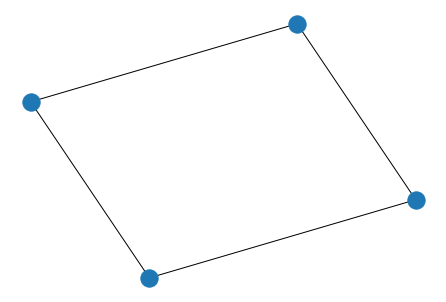

In [23]:
graph = nx.Graph([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(graph)
plt.show()

In [24]:
cost_h, mixer_h = qaoa.maxcut(graph)
print(cost_h)
print(mixer_h)

(-0.5) [I0 I1]
+ (0.5) [Z0 Z1]
+ (-0.5) [I0 I3]
+ (0.5) [Z0 Z3]
+ (-0.5) [I1 I2]
+ (0.5) [Z1 Z2]
+ (-0.5) [I2 I3]
+ (0.5) [Z2 Z3]
(1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [25]:
dev = qml.device('qulacs.simulator', wires=4)

# Defines the QAOA layer

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

# Defines the full circuit

def circuit(params, **kwargs):
    
    for i in range(4):
        qml.Hadamard(wires=i)
    
    qml.layer(qaoa_layer, 2, params[0], params[1])
    
# Defines the cost function

cost_function = qml.VQECost(circuit, cost_h, dev)

# Optimizes the cost function

optimizer = qml.GradientDescentOptimizer()
params = [[0.5, 0.5], [0.5, 0.5]]

for i in range(50):
    params = optimizer.step(cost_function, params)
    print("Done Step: {}/30".format(i+1))

print(params)

Done Step: 1/30
Done Step: 2/30
Done Step: 3/30
Done Step: 4/30
Done Step: 5/30
Done Step: 6/30
Done Step: 7/30
Done Step: 8/30
Done Step: 9/30
Done Step: 10/30
Done Step: 11/30
Done Step: 12/30
Done Step: 13/30
Done Step: 14/30
Done Step: 15/30
Done Step: 16/30
Done Step: 17/30
Done Step: 18/30
Done Step: 19/30
Done Step: 20/30
Done Step: 21/30
Done Step: 22/30
Done Step: 23/30
Done Step: 24/30
Done Step: 25/30
Done Step: 26/30
Done Step: 27/30
Done Step: 28/30
Done Step: 29/30
Done Step: 30/30
Done Step: 31/30
Done Step: 32/30
Done Step: 33/30
Done Step: 34/30
Done Step: 35/30
Done Step: 36/30
Done Step: 37/30
Done Step: 38/30
Done Step: 39/30
Done Step: 40/30
Done Step: 41/30
Done Step: 42/30
Done Step: 43/30
Done Step: 44/30
Done Step: 45/30
Done Step: 46/30
Done Step: 47/30
Done Step: 48/30
Done Step: 49/30
Done Step: 50/30
[[0.7998633542617706, -0.31673443245632377], [0.5093314516288767, 0.6341850352824214]]


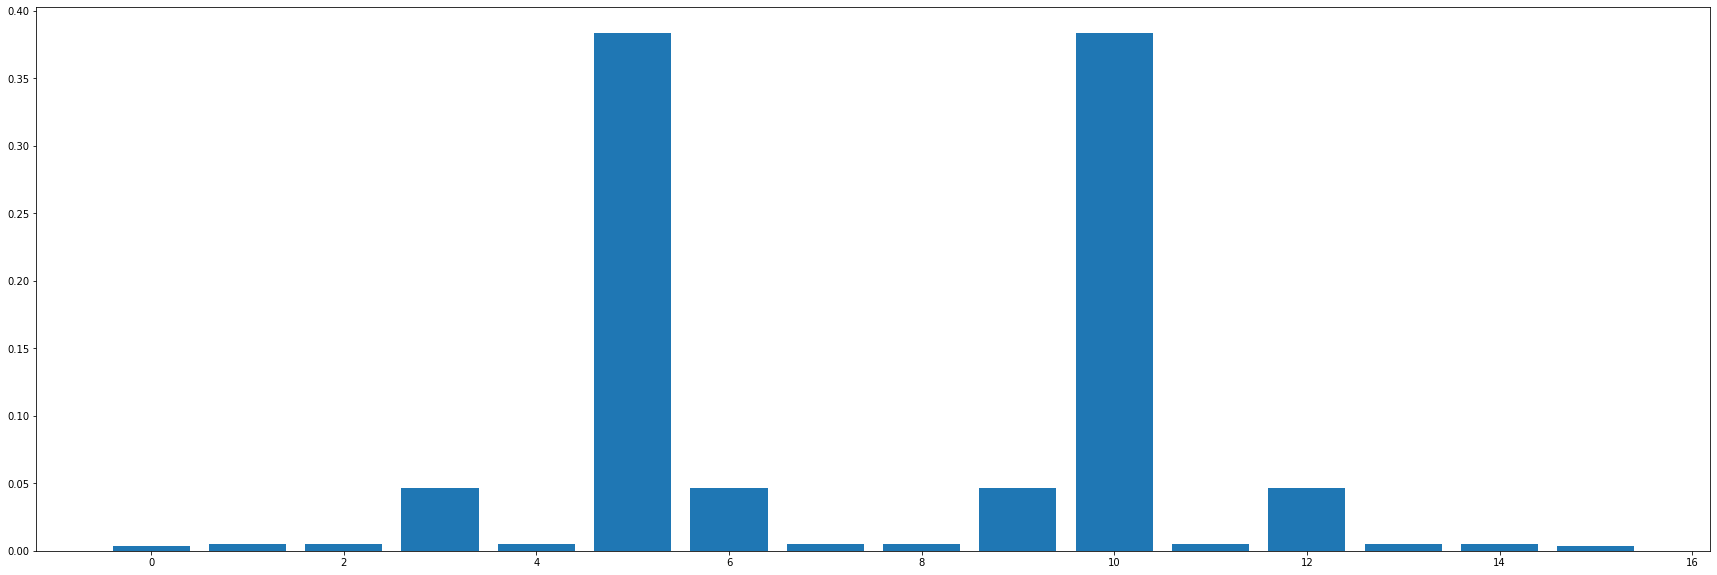

In [26]:
# Defines a circuit

@qml.qnode(dev)
def ansatz(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=range(4))

dict_vals = ansatz(params[0], params[1])

plt.figure(figsize=(30, 10))
plt.bar(range(2**4), dict_vals)
plt.show()